# Interpretability

## Import Libraries

In [1]:
import os
from datetime import datetime
import pickle

import logging
import warnings
warnings.filterwarnings("ignore")

_ABSOLUTE_DIR = os.getcwd()
_NOTEBOOK_START = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
if not os.path.exists('logs'):
    # Create a new directory because it does not exist 
    os.makedirs('logs')
logging.basicConfig(filename=f'logs/heart_processing_{_NOTEBOOK_START}.log', encoding='utf-8', level=logging.DEBUG, format='%(levelname)s:%(asctime)s:%(message)s')

import tqdm as notebook_tqdm
import seaborn as sns
import matplotlib.pyplot as plt

import shap
import lime

import pandas as pd
import numpy as np

from scipy import stats

from sklearn.svm import LinearSVC
from xgboost import XGBClassifier
logging.info(f'Imports loaded')

## Import Data

In [2]:
## Models

with open(f'../artifacts/models/heart_svc_model_1.pickle', 'rb') as pickle_file:
    SVC_model_1 = pickle.load(pickle_file)

with open(f'../artifacts/models/heart_xgb_model_1.pickle', 'rb') as pickle_file:
    XGBoost_model_1 = pickle.load(pickle_file)


In [3]:
## Data

dfHeart_processed = pd.read_parquet(f'../artifacts/data/heart/heart_processed.parquet')
logging.info(f'Load dataset from ../artifacts/data/heart/heart_processed.parquet')

dfHeart_processed['diabetic_no_fe'] = dfHeart_processed['diabetic_no_fe'].astype(int)
dfHeart_processed['MentalHealth'] = dfHeart_processed['MentalHealth'].astype(int)
dfHeart_processed['PhysicalHealth'] = dfHeart_processed['PhysicalHealth'].astype(int)
dfHeart_processed['DiffWalking'] = dfHeart_processed['DiffWalking'].astype(int)
dfHeart_processed['Smoking'] = dfHeart_processed['Smoking'].astype(int)

columns_v1 = ['AgeCategory_seq_fe', 
              'BMI_scaled', 
              'GenHealth', 
              'Smoking', 
              'PriorDiseases', 
              'diabetic_no_fe', 
              'DiffWalking', 
              'MentalHealth', 
              'PhysicalHealth']

train_data = dfHeart_processed[(dfHeart_processed['Set'] == 'train')]
test_data = dfHeart_processed[(dfHeart_processed['Set'] == 'test')]
val_data = dfHeart_processed[(dfHeart_processed['Set'] == 'valid')]

X_train = train_data[columns_v1]
y_train = train_data['HeartDisease']

X_test = test_data[columns_v1]
y_test = test_data['HeartDisease']

X_val = val_data[columns_v1]
y_val = val_data['HeartDisease']

In [4]:
## Transformation Map

with open(f'../artifacts/transformation_maps/heart/bmi_scaler.pickle', 'rb') as pickle_file:
    StandardScaler_map = pickle.load(pickle_file)

## SHAP

In [5]:
test_x_set = X_test.sample(500, random_state = 123)

In [55]:
test_y_set = y_test.loc[test_x_set.index]

In [19]:
explainer_LinearSVC = shap.Explainer(SVC_model_1.predict, X_train)
shap_values_LinearSVC = explainer_LinearSVC(test_x_set)

Exact explainer: 501it [02:35,  3.04it/s]                         


In [18]:
shap_values_LinearSVC

.values =
array([[[-0.28794246,  0.28794246],
        [-0.00271032,  0.00271032],
        [-0.03676627,  0.03676627],
        ...,
        [ 0.01875754, -0.01875754],
        [-0.01942341,  0.01942341],
        [-0.09125794,  0.09125794]],

       [[ 0.0128123 , -0.0128123 ],
        [-0.00695317,  0.00695317],
        [ 0.31824444, -0.31824444],
        ...,
        [ 0.03046468, -0.03046468],
        [-0.01770675,  0.01770675],
        [-0.03833413,  0.03833413]],

       [[-0.08248532,  0.08248532],
        [-0.00196032,  0.00196032],
        [-0.16630437,  0.16630437],
        ...,
        [ 0.01595278, -0.01595278],
        [ 0.00301944, -0.00301944],
        [-0.05909246,  0.05909246]],

       ...,

       [[ 0.06558452, -0.06558452],
        [-0.00196786,  0.00196786],
        [ 0.23851905, -0.23851905],
        ...,
        [ 0.02007976, -0.02007976],
        [-0.00978095,  0.00978095],
        [-0.01776071,  0.01776071]],

       [[-0.08492738,  0.08492738],
        [-0.00088

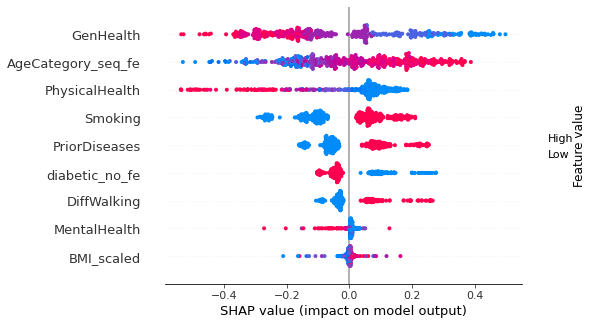

In [22]:
shap.summary_plot(shap_values_LinearSVC.values, test_x_set, feature_names = X_train.columns)

In [84]:
explainer_XGB = shap.Explainer(XGBoost_model_1.predict, X_train)
shap_values_XGB = explainer_XGB(test_x_set)


#explainer_XGB = shap.TreeExplainer(XGBoost_model_1.predict, X_train)
#shap_values_XGB = explainer_XGB(test_x_set)

Exact explainer: 501it [00:27, 11.31it/s]                         


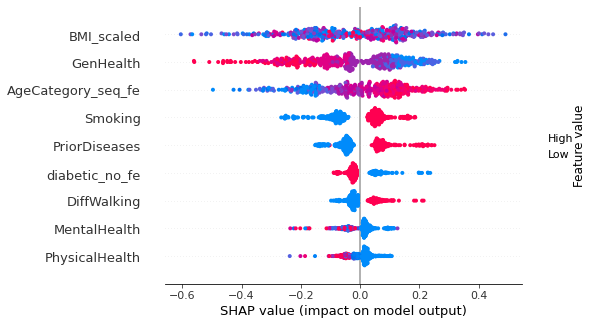

In [88]:
shap.summary_plot(shap_values_XGB.values, test_x_set)

## Are there significant differences?



In [58]:
transposed_LinearSVC_shap= shap_values_LinearSVC.values.T
transposed_XGB_shap = shap_values_XGB.values.T

Feature AgeCategory_seq_fe


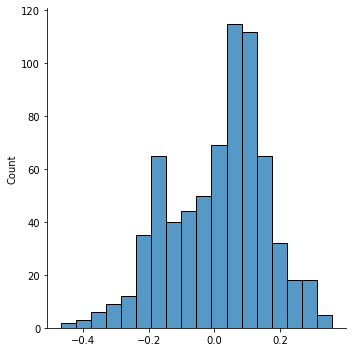

Feature BMI_scaled


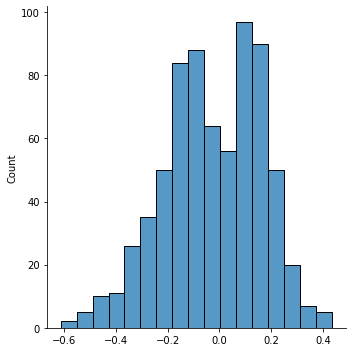

Feature GenHealth


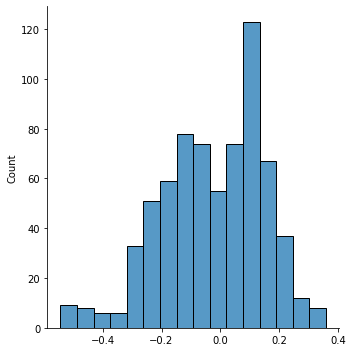

Feature Smoking


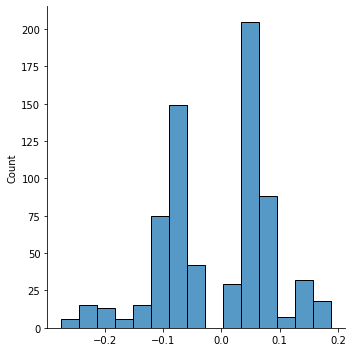

Feature PriorDiseases


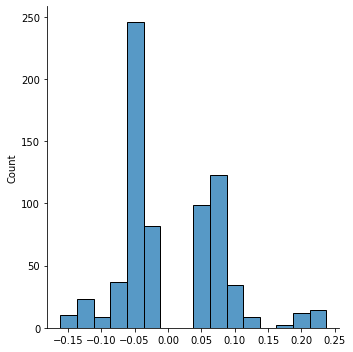

Feature diabetic_no_fe


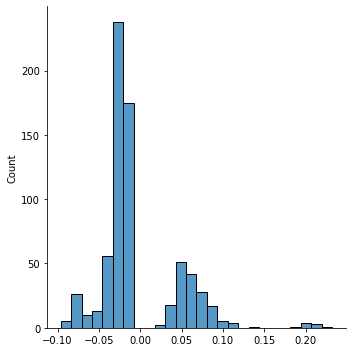

Feature DiffWalking


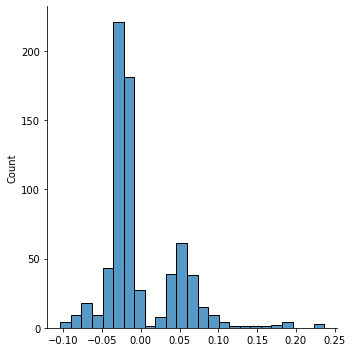

Feature MentalHealth


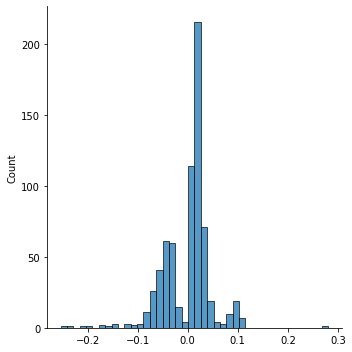

Feature PhysicalHealth


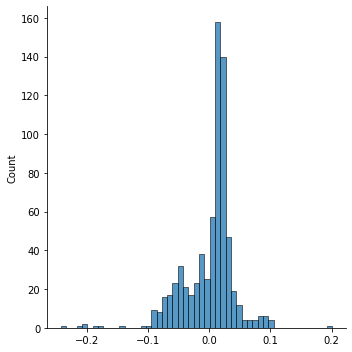

In [68]:
for i in range(0,9):
    print(f'Feature {test_x_set.columns[i]}')
    sns.displot(shap_values_XGB.values[:,i])
    plt.show()

shap_values_LinearSVC.values

### Assumptions


1. The first assumption made regarding t-tests concerns the scale of measurement. The assumption for a t-test is that the scale of measurement applied to the data collected follows a continuous or ordinal scale, such as the scores for an IQ test.
2. The second assumption made is that of a simple random sample, that the data is collected from a representative, randomly selected portion of the total population.
3. The third assumption is the data, when plotted, results in a normal distribution, bell-shaped distribution curve.
4. The final assumption is the homogeneity of variance. Homogeneous, or equal, variance exists when the standard deviations of samples are approximately equal.


1 and 2 are verified by the process we followed so far.  
We need to check 3 and 4.  
The 3rd is with a t-test, and the 4th will be done with a levene test.

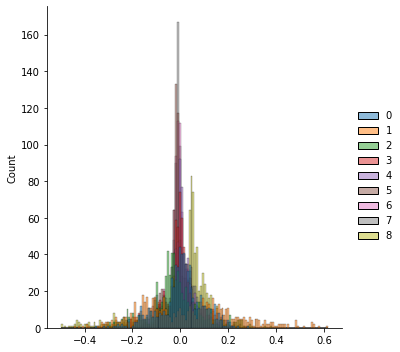

In [69]:
mu_list = []
for i in range(0,9):
    mu_list.append(shap_values_LinearSVC.values[:,i] - shap_values_XGB.values[:,i])

sns.displot(mu_list)

Feature AgeCategory_seq_fe
LeveneResult(statistic=33.47970835815255, pvalue=8.874921800148985e-09)
We don't reject the null hypothises at 8.874921800148985e-09



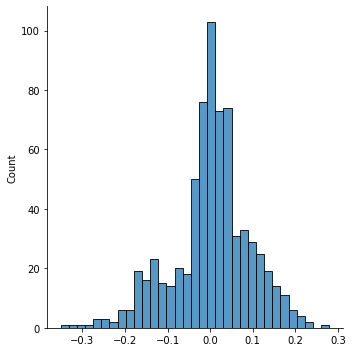



Feature BMI_scaled
LeveneResult(statistic=1355.4289223498924, pvalue=5.252495661832218e-208)
We don't reject the null hypothises at 5.252495661832218e-208



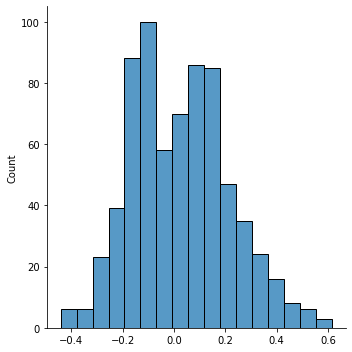



Feature GenHealth
LeveneResult(statistic=36.33677300198253, pvalue=2.1204237734992826e-09)
We don't reject the null hypothises at 2.1204237734992826e-09



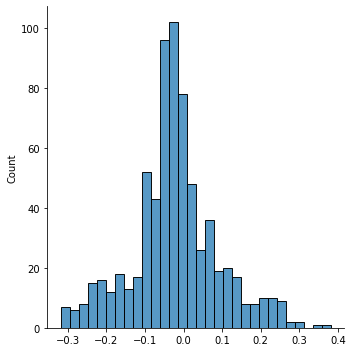



Feature Smoking
LeveneResult(statistic=59.03576179558852, pvalue=2.897760515584091e-14)
We don't reject the null hypothises at 2.897760515584091e-14



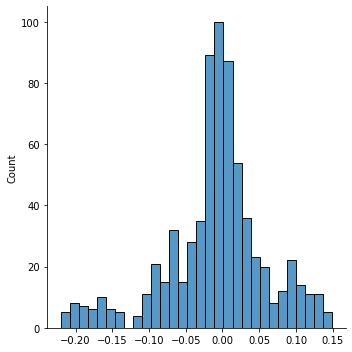



Feature PriorDiseases
LeveneResult(statistic=42.32146398880536, pvalue=1.0757801901188167e-10)
We don't reject the null hypothises at 1.0757801901188167e-10



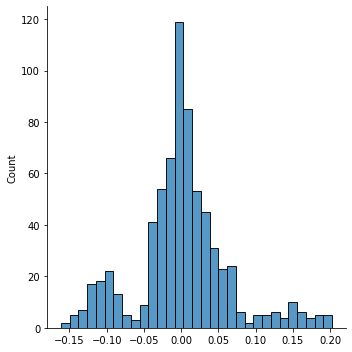



Feature diabetic_no_fe
LeveneResult(statistic=50.0312725235812, pvalue=2.3841597251671713e-12)
We don't reject the null hypothises at 2.3841597251671713e-12



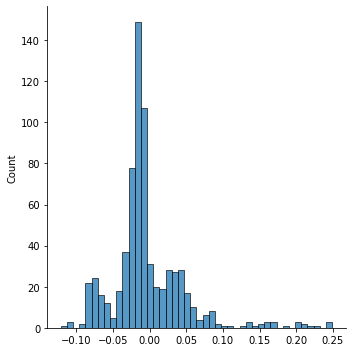



Feature DiffWalking
LeveneResult(statistic=18.294337506779552, pvalue=2.021235826389708e-05)
We don't reject the null hypothises at 2.021235826389708e-05



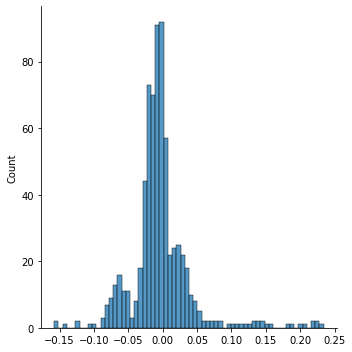



Feature MentalHealth
LeveneResult(statistic=149.6492522197879, pvalue=9.161412328208274e-33)
We don't reject the null hypothises at 9.161412328208274e-33



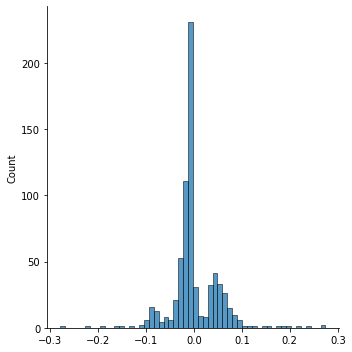



Feature PhysicalHealth
LeveneResult(statistic=147.79994746033935, pvalue=2.1248407632241126e-32)
We don't reject the null hypothises at 2.1248407632241126e-32



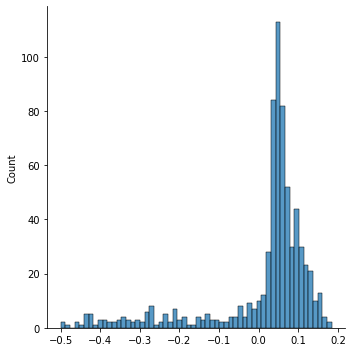

In [73]:
for i in range(0,9):
    print(f'Feature {test_x_set.columns[i]}')
    sns.displot(mu_list[i])
    levene = stats.levene(shap_values_LinearSVC.values[:,i], shap_values_XGB.values[:,i])
    print(levene)
    print(f"We don't reject the null hypothises at {levene.pvalue}\n")
    plt.show()
    print("\n")

In all distributions, the difference is very much around the value 0 of mu.

### T-test



In [86]:
for i in range(0, 9):
    print(f'Feature {test_x_set.columns[i]}')
    t_test = stats.ttest_rel(shap_values_LinearSVC.values[:,i], shap_values_XGB.values[:,i])
    print('At 5% significance, we:')
    if t_test.pvalue > 0.05:
        print(f"\treject the null hypothises at p-value {t_test.pvalue}: > 0.05\n")
    else:
        print(f"\tdon't reject the null hypothises at p-value: {t_test.pvalue}% < 0.05\n")

Feature AgeCategory_seq_fe
At 5% significance, we:
	reject the null hypothises at p-value 0.3356140529903201: > 0.05

Feature BMI_scaled
At 5% significance, we:
	don't reject the null hypothises at p-value: 0.02966644426526197% < 0.05

Feature GenHealth
At 5% significance, we:
	don't reject the null hypothises at p-value: 0.0026310670961811524% < 0.05

Feature Smoking
At 5% significance, we:
	reject the null hypothises at p-value 0.11321552529333595: > 0.05

Feature PriorDiseases
At 5% significance, we:
	reject the null hypothises at p-value 0.3194708783421282: > 0.05

Feature diabetic_no_fe
At 5% significance, we:
	reject the null hypothises at p-value 0.28726567030402195: > 0.05

Feature DiffWalking
At 5% significance, we:
	reject the null hypothises at p-value 0.7508925771749211: > 0.05

Feature MentalHealth
At 5% significance, we:
	reject the null hypothises at p-value 0.7134686232479841: > 0.05

Feature PhysicalHealth
At 5% significance, we:
	reject the null hypothises at p-value 

Experiment 1 (E1): 
* Seed : 999
* Number of samples: 700

Experiment 2 (E2): 
* Seed : 42
* Number of samples: 500

Experiment 3 (E3): 
* Seed : 123
* Number of samples: 500


| Feature            | E1     | E2     | E3      |
|--------------------|--------|--------|---------|
| AgeCategory_seq_fe | 0.4681 | 0.4305 | 0.3356  |
| BMI_scaled         | 0.0002 | 0.0000 | 0.02967 |
| GenHealth          | 0.0000 | 0.0000 | 0.0026  |
| Smoking            | 0.0003 | 0.0011 | 0.1132  |
| PriorDiseases      | 0.5283 | 0.8330 | 0.3194  |
| diabetic_no_fe     | 0.0826 | 0.0815 | 0.2873  |
| DiffWalking        | 0.0144 | 0.1774 | 0.7508  |
| MentalHealth       | 0.8025 | 0.0156 | 0.7134  |
| PhysicalHealth     | 0.0319 | 0.0159 | 0.0517  |

We can conclude that the shap values are significantly different with some observations, and not with others. A conjecture is that they are going to be different with the whole dataset (We can't calculate for the full test dataset due to time constraints)

## One sample examples



In [90]:
test_x_set_2 = X_test.sample(1, random_state = 123)

In [91]:
explainer_LinearSVC = shap.Explainer(SVC_model_1.predict, X_train)
shap_values_LinearSVC = explainer_LinearSVC(test_x_set_2)

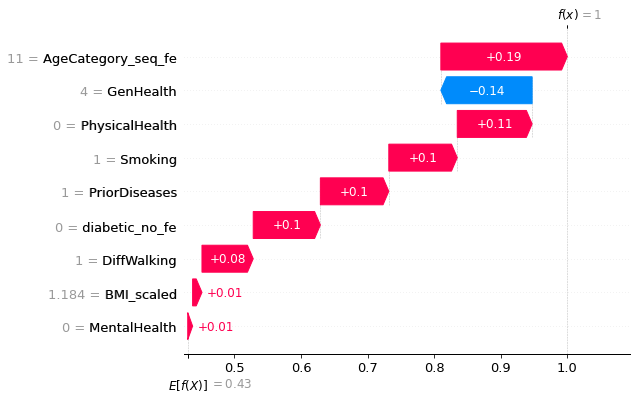

In [47]:
shap.plots.waterfall(shap_values_LinearSVC[66], max_display=14)

In [66]:
shap.initjs()
i = 60
print(test_y_set.iloc[i])
shap.force_plot(base_value=shap_values_LinearSVC[i].base_values, shap_values=shap_values_LinearSVC[i].values, feature_names=test_x_set.columns)

True


In [38]:
shap_values_LinearSVC

.values =
array([[ 0.3403254 ,  0.01300397,  0.00968254, ..., -0.03463889,
         0.00600397,  0.1420754 ],
       [-0.03227778, -0.00352778, -0.35740873, ..., -0.02898016,
         0.00306746,  0.06806746],
       [ 0.07467857, -0.0074881 ,  0.20244048, ..., -0.02933333,
         0.00291667,  0.06458333],
       ...,
       [-0.05221429,  0.00192857, -0.21470238, ..., -0.02746429,
         0.00546429,  0.03209524],
       [ 0.2061746 ,  0.00359127,  0.43430556, ..., -0.05071825,
         0.00262698, -0.32369444],
       [-0.16753571, -0.08779762,  0.29972619, ...,  0.08203571,
        -0.20308333, -0.4589881 ]])

.base_values =
array([0.43, 0.43, 0.43, 0.43, 0.43, 0.43, 0.43, 0.43, 0.43, 0.43, 0.43,
       0.43, 0.43, 0.43, 0.43, 0.43, 0.43, 0.43, 0.43, 0.43, 0.43, 0.43,
       0.43, 0.43, 0.43, 0.43, 0.43, 0.43, 0.43, 0.43, 0.43, 0.43, 0.43,
       0.43, 0.43, 0.43, 0.43, 0.43, 0.43, 0.43, 0.43, 0.43, 0.43, 0.43,
       0.43, 0.43, 0.43, 0.43, 0.43, 0.43, 0.43, 0.43, 0.43, 0.43, 0.